# Group Normalization
Examination Project at Ulm Univerisity  

**Presented by:**  
Carolin Schindler, carolin.schindler@uni-ulm.de

**Primary instructor:**  
Prof. Dr. Heiko Neumann  
**Secondary instructor:**  
M.Sc. Christian Jarvers

DeepVision - Deep Learning and Convolutional Neural Networks in Computational Vision (2021)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Layer, BatchNormalization,
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ReLU,
    GlobalAveragePooling2D, add
)
from tensorflow.keras.models import Model

from matplotlib import pyplot as plt
from matplotlib import ticker
%matplotlib inline

import itertools
import numpy as np

In [ ]:
# mount google drive (if in Colab)
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/DeepVision/

## 1. Load and Prepare the Fashion-MNIST Dataset
The Fashion-MNIST dataset by  [Xiao et al. (2017)](https://arxiv.org/pdf/1708.07747.pdf) is a collection of grayscale images of fashion items belonging to ten different classes:  
0. T-Shirt/Top
1. Trousers
2. Pullover
3. Dress
4. Coat
5. Sandals
6. Shirt
7. Sneaker
8. Bag
9. Ankle boots

The dataset contains a total of 70 000 images: 60 000 training examples and 10 000 examples for testing. The images have a width and height of 28 pixels.

In [2]:
# load data
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.fashion_mnist.load_data()

# normalize pixel values to range [0,1]
train_imgs = train_imgs / 255.0
test_imgs = test_imgs / 255.0

# add channel dimension (not explecitly given in the dataset as channel dimension = 1 for grayscale)
train_imgs = tf.expand_dims(train_imgs, axis=3)
test_imgs = tf.expand_dims(test_imgs, axis=3)

# set parameters for input and output shape
input_shape = (28, 28, 1)
output_classes = 10

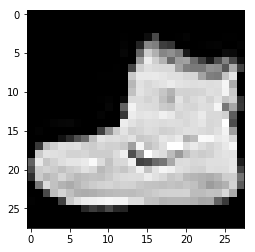

In [3]:
# check dataset
pos = 0
plt.imshow(train_imgs[pos, :, :, 0], cmap="gray")
plt.show()

## 2. GroupNormalization Layer
Keras offers an implementation for the following two [Normalization layers](https://keras.io/api/layers/normalization_layers/): BatchNormalization and LayerNormalization. Hence, we implement our own GroupNormalization layer in this section.

The group_normalization function is an adaption from [Wu and He (2020)](https://link.springer.com/article/10.1007/s11263-019-01198-w) (Figure 3). Their implementation assumes input features with a shape of [N, C, H, W] (N: batch size, C: number channels, H: height, W: width), but the default representation in Tensorflow is [N, H, W, C] and thus the adaption.  
The implementation of the GroupNormalization layer is inspired by the already existing [Normalization layers](https://keras.io/api/layers/normalization_layers/): It allows for en- and disabling centering by $\beta$ and scaling by $\gamma$ and it allows to set initializers, regularizers and constraints for the learnable parameters $\beta$ and $\gamma$.

In [4]:
def group_normalization(x, gamma, beta, G, eps):
    # x: input features with shape [N,H,W,C]
    # gamma, beta: scale and offset with shape [1,1,1,C]
    # G: number of groups for GN

    N, H, W, C = (-1 if dim is None else dim for dim in x.shape)
    G = min(C,G) # C // G should be at least 1
    x = tf.reshape(x, [N, H, W, G, C // G])

    mean, var = tf.nn.moments(x, [1, 2, 4], keepdims=True)
    
    x = (x - mean) / tf.sqrt(var + eps)
    x = tf.reshape(x, [N, H, W, C])
    
    return x * gamma + beta

class GroupNormalization(Layer):
    def __init__(self, G=32, epsilon=1e-5,
                 center = True, scale = True,
                 beta_initializer='zeros', gamma_initializer='ones',
                 beta_regularizer=None, gamma_regularizer=None,
                 beta_constraint=None, gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.G = G
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = tf.keras.initializers.get(beta_initializer)
        self.gamma_initializer = tf.keras.initializers.get(gamma_initializer)
        self.beta_regularizer = tf.keras.regularizers.get(beta_regularizer)
        self.gamma_regularizer = tf.keras.regularizers.get(gamma_regularizer)
        self.beta_constraint = tf.keras.constraints.get(beta_constraint)
        self.gamma_constraint = tf.keras.constraints.get(gamma_constraint)
    
    def build(self, input_shape):
        _, _, _, C = input_shape
        if self.scale:
            self.gamma = self.add_weight(shape=[1, 1, 1, C],
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint,
                                         trainable=True,
                                         name='gamma')
        else:
            self.gamma = 1
            
        if self.center:
            self.beta = self.add_weight(shape=[1, 1, 1, C],
                                         initializer=self.beta_initializer,
                                         regularizer=self.beta_regularizer,
                                         constraint=self.beta_constraint,
                                         trainable=True,
                                         name='beta')
        else:
            self.beta = 0
        
    
    def call(self, inputs):
        # no differentiation between training=True and training=False as batch size is not used
        return group_normalization(inputs, self.gamma, self.beta, self.G, self.epsilon)

## 3. Models (with [Functional API](https://keras.io/guides/functional_api/))
In this section, we implement different models, which are then used to compare Batch Normalization and Group Normalization for different batch sizes.  

As our networks are smaller and hence contain convolutions with a smaller amount of filters, we set the hyper-parameter G (which is the number of groups for the Group Normalization) to 16 instead of the default value 32 (in order to prevent Group Normalization to be equivalent to Layer Normalization).

In [5]:
def normalization_layer(normalization, gamma_initializer='ones', regularizer=None):
    if normalization == 'GroupNorm':
        return GroupNormalization(G=16,
                                  gamma_initializer=gamma_initializer,
                                  beta_regularizer=regularizer,
                                  gamma_regularizer=regularizer)
    if normalization == 'BatchNorm':
        return BatchNormalization(gamma_initializer=gamma_initializer,
                                  beta_regularizer=regularizer,
                                  gamma_regularizer=regularizer)
    raise Exception("normalization is not 'GroupNorm' or 'BatchNorm'")

The order of creation and evaluation of the models was: ResNet-18, DCNN, CNN and finally "default DCNN". Hence, we follow this order for the presentation, but "default DCNN" is the only model that was able to roughly reproduce the results from Figure 1 by [Wu and He (2020)](https://link.springer.com/article/10.1007/s11263-019-01198-w).

### 3.1 ResNet-18

It was tried to reproduce the results with a ResNet-18 ([He et al. (2015)](https://arxiv.org/pdf/1512.03385.pdf)) with pre-activation.  
Following [Wu and He's (2020)](https://link.springer.com/article/10.1007/s11263-019-01198-w) experimental setup for the image classification on ImageNet (they applied a ResNet-50), we applied He-initialization for all convolutional layers, weight decay in form of the L2-regularizer with regularization factor 0.0001 for all weight layers (including the normalization layers) and we initialized $\gamma$ with zeros instead of ones in the last normalization layer of each residual block.

Unfortunately, the results from the paper could not be reproduced with ResNet-18 on the Fashion-MNIST dataset (see Section 6 for more details).

In [6]:
def residual_block(input_layer, nb_filters, normalization, projection_shortcut= False,
                   regularizer=None):
    
    # identity mapping or projection shortcut --> input or 1x1 convolution
    if projection_shortcut:
        stride = 2
        skip_connection = Conv2D(nb_filters, kernel_size=1, strides=stride, padding='same',
                                 kernel_initializer='he_normal',
                                 kernel_regularizer=regularizer)(input_layer)
    else:
        stride = 1
        skip_connection = input_layer
    
    # pre-acitvation --> N ReLU weight ... N ReLU weight addition
    x = normalization_layer(normalization, regularizer=regularizer)(input_layer)
    x = ReLU()(x)
    x = Conv2D(nb_filters, kernel_size=3, strides=stride, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizer)(x)
    
    x = normalization_layer(normalization, regularizer=regularizer,
                            gamma_initializer='zeros')(x)
    x = ReLU()(x)
    x = Conv2D(nb_filters, kernel_size=3, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizer)(x)
    
    # skip connection
    output = add([x, skip_connection])
    
    return output

def resnet18(input_layer, num_classes, normalization, regularizer=tf.keras.regularizers.l2(0.0001)):
    # 1 conv7x7
    x = Conv2D(64, kernel_size=7, strides=2, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizer)(input_layer)
    x = normalization_layer(normalization, regularizer=regularizer)(x)
    x = ReLU()(x)

    # pooling
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # 16 conv3x3 layers
    x = residual_block(x, 64, normalization, regularizer=regularizer)
    x = residual_block(x, 64, normalization, regularizer=regularizer)

    x = residual_block(x, 128, normalization, True, regularizer=regularizer)
    x = residual_block(x, 128, normalization, regularizer=regularizer)

    x = residual_block(x, 256, normalization, True, regularizer=regularizer)
    x = residual_block(x, 256, normalization, regularizer=regularizer)

    x = residual_block(x, 512, normalization, True, regularizer=regularizer)
    x = residual_block(x, 512, normalization, regularizer=regularizer)

    # avg pooling
    x = GlobalAveragePooling2D()(x)

    # 1 dense layer
    y = Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)(x)
    return y

In [7]:
# check model
inputs = Input(shape=input_shape)
outputs = resnet18(input_layer=inputs, num_classes=output_classes, normalization='GroupNorm')
model = Model(inputs=inputs, outputs=outputs, name="ResNet18")
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
group_normalization (GroupNorma (None, 14, 14, 64)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 14, 14, 64)   0           group_normalization[0][0]        
___________________________________________________________________________________________

### 3.2 Deep Convolutional Neural Network (DCNN)

It was tried to reproduce the results with a DCNN ([Sze et al. (2017)](https://arxiv.org/pdf/1703.09039.pdf), i.e. Figure 10).  
L2-regularization and He-initialization was applied like for the ResNet-18. In the Dense layers we did not apply normalization (as Group Normalization, without turning it into a form of Instance Normalization, is only valid for convolutional layers), instead we apply Dropout with a rate of 0.5.

Unfortunately, the results from the paper could only be reproduced partially with the DCNN on the Fashion-MNIST dataset (see Section 6 for more details).

In [8]:
def convolutional_block(input_layer, filters, kernel_size, normalization, regularizer=None):
    x = Conv2D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizer)(input_layer)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizer)(x)
    x = ReLU()(x)

    x = normalization_layer(normalization, regularizer=regularizer)(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    return x

def dense_block(input_layer, units, dropout_rate=0.5, regularizer=None):
    x = Dense(units, kernel_regularizer=regularizer)(input_layer)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    return x

def dcnn(input_layer, num_classes, normalization,
         regularizer=tf.keras.regularizers.l2(0.0001)):
    # convolutional layers
    x = convolutional_block(input_layer, 32, 5, normalization, regularizer=regularizer)
    x = convolutional_block(x, 64, 3, normalization, regularizer=regularizer)
    x = convolutional_block(x, 128, 3, normalization, regularizer=regularizer)
    x = convolutional_block(x, 256, 3, normalization, regularizer=regularizer)

    y = Flatten()(x)
    # dense layers
    y = dense_block(y, 128)
    y = dense_block(y, 64)
    y = Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)(y)

    return y

In [9]:
# check model
inputs = Input(shape=input_shape)
outputs = dcnn(input_layer=inputs, num_classes=output_classes, normalization='GroupNorm')
model = Model(inputs=inputs, outputs=outputs, name="DCNN")
model.summary()

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
re_lu_17 (ReLU)              (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
re_lu_18 (ReLU)              (None, 28, 28, 32)        0         
_________________________________________________________________
group_normalization_17 (Grou (None, 28, 28, 32)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0      

### 3.3 Convolutional Neural Network (CNN)

It was tried to reproduce the results with a CNN ([LeCun et al. (2010)](https://ieeexplore.ieee.org/document/5537907)).  
L2-regularization and He-initialization was applied like for the above two models. For better training, we applied Dropout with a rate of 0.5 instead of 0.25 (compare DCNN) in the Dense layers.

Unfortunately, the results from the paper could only be reproduced partially with the CNN on the Fashion-MNIST dataset (see Section 6 for more details).

In [10]:
def convolutional_layer(input_layer, filters, kernel_size, normalization, regularizer=None):
    x = Conv2D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizer)(input_layer)
    x = normalization_layer(normalization, regularizer=regularizer)(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    return x

def dense_layer(input_layer, units, dropout_rate, regularizer=None):
    x = Dense(units, kernel_regularizer=regularizer)(input_layer)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    return x

def cnn(input_layer, num_classes, normalization,
         dropout_rate=0.25, regularizer=tf.keras.regularizers.l2(0.0001)):
    x = convolutional_layer(input_layer, 32, 5, normalization, regularizer=regularizer)
    x = convolutional_layer(x, 64, 3, normalization, regularizer=regularizer)
    
    y = Flatten()(x)
    y = Dropout(dropout_rate)(y)
    y = dense_layer(y, 128, dropout_rate)
    y = Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)(y)

    return y

In [11]:
# check model
inputs = Input(shape=input_shape)
outputs = cnn(input_layer=inputs, num_classes=output_classes, normalization='GroupNorm')
model = Model(inputs=inputs, outputs=outputs, name="CNN")
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
group_normalization_21 (Grou (None, 28, 28, 32)        64        
_________________________________________________________________
re_lu_27 (ReLU)              (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
group_normalization_22 (Grou (None, 14, 14, 64)        128     

### 3.4 "Default Deep Convolutional Neural Network" ("default DCNN")
The results could be roughly reduced with the following DCNN ([Sze et al. (2017)](https://arxiv.org/pdf/1703.09039.pdf), i.e. Figure 10).  
It is named "default DCNN" by us as it does not apply regularization to the weight layers and does not use He-initialization for the convolutional layers (which all above models do), thus it uses the default parameters of the respective layers. Dropout is applied with a rate of 0.5 like for the above DCNN.

In [12]:
def default_convolutional_block(input_layer, filters, kernel_size, normalization):
    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(input_layer)
    x = ReLU()(x)
    x = normalization_layer(normalization)(x)

    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = ReLU()(x)
    x = normalization_layer(normalization)(x)

    x = MaxPooling2D(pool_size=2, strides=2)(x)

    return x

def default_dense_block(input_layer, units, dropout_rate=0.5):
    x = Dense(units)(input_layer)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    return x

def default_dcnn(input_layer, num_classes, normalization):
    # convolutional layers
    x = default_convolutional_block(input_layer, 32, 5, normalization)
    x = default_convolutional_block(x, 64, 3, normalization)
    x = default_convolutional_block(x, 128, 3, normalization)
    x = default_convolutional_block(x, 256, 3, normalization)

    y = Flatten()(x)
    # dense layers
    y = default_dense_block(y, 128)
    y = default_dense_block(y, 64)
    y = Dense(num_classes, activation='softmax')(y)

    return y

In [13]:
# check model
inputs = Input(shape=input_shape)
outputs = default_dcnn(input_layer=inputs, num_classes=output_classes, normalization='GroupNorm')
model = Model(inputs=inputs, outputs=outputs, name="default DCNN")
model.summary()

Model: "default DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
re_lu_30 (ReLU)              (None, 28, 28, 32)        0         
_________________________________________________________________
group_normalization_23 (Grou (None, 28, 28, 32)        64        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
re_lu_31 (ReLU)              (None, 28, 28, 32)        0         
_________________________________________________________________
group_normalization_24 (Grou (None, 28, 28, 32)       

## 4. Model with different Batch Sizes and Normalizers
The evaluation of the performance of a model with different batch sizes and normalizers requires creating several models. We compare the model using BatchNormalization layers with the model using GroupNormalization layers over the batch sizes 32, 16, 8, 4, 2 (batch sizes were selected according to [Wu and He (2020)](https://link.springer.com/article/10.1007/s11263-019-01198-w), Figure 1).  
We apply the sparse categorical crossentropy as a loss function for the classification task and use the Adam optimizer.

If you want to use the CNN, DCNN or ResNet-18 model instead of the "default DCNN", change the folder (in the next cell) to the respective one ("CNN/", "DCNN/", "ResNet18/", "default_DCNN/") and make sure that you have run the code above for the model of choice.

In [ ]:
# Attention: change this folder if you want to train / load weights for other models
folder = "default_DCNN/"

In [ ]:
batch_sizes = [32, 16, 8, 4, 2]
normalizations = ['BatchNorm', 'GroupNorm']

models = []

for normalization, batch_size in itertools.product(normalizations, batch_sizes):
    name = normalization + "_" + str(batch_size)
    inputs = Input(shape=input_shape)
    if folder == "default_DCNN/":
        outputs = default_dcnn(input_layer=inputs, num_classes=output_classes, normalization=normalization)
    elif folder == "CNN/":
        outputs = cnn(input_layer=inputs, num_classes=output_classes, normalization=normalization)
    elif folder == "DCNN/":
        outputs = dcnn(input_layer=inputs, num_classes=output_classes, normalization=normalization)
    elif folder == "ResNet18/":
        outputs = resnet18(input_layer=inputs, num_classes=output_classes, normalization=normalization)
    else:
        raise Exception("unknown model: cannot be created")
    
    model = Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    models.append(model)
    print("Created model: " + model.name)

## 5. Train the Models
The training can be skipped, if wanted: Pre-trained weights for each model are saved in the respective folder/directory and can be loaded with the code in the next section (for ResNet-18 only the models using Batch Normalization were trained).

All "default DCNN" and CNN models were trained for 15 epochs, the DCNN and ResNet-18 models were trained for 25 epochs (as then they are all close to convergence and the overfitting remains minimal). Note that the training setup is the same for all models of the same type despite the batch size and the kind of normalization layers used in the models.

In [ ]:
if folder == "default_DCNN/":
    train_epochs = 15
elif folder == "CNN/":
    train_epochs = 15
elif folder == "DCNN/":
    train_epochs = 25
elif folder == "ResNet18/":
    train_epochs = 25
else:
    raise Exception("unknown model: tain_epochs not known")

def plot_acc_loss(title, epochs, history):
    x = range(1, epochs+1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*6.4, 4.8))
    fig.suptitle(title, fontsize=14)
    
    ax1.plot(x, history.history['accuracy'],'b-',label='training')
    ax1.plot(x, history.history['val_accuracy'],'r-',label='validation')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy', fontsize=14)
    ax1.legend(loc='upper left', fontsize=14)

    ax2.plot(x, history.history['loss'],'b-',label='training')
    ax2.plot(x, history.history['val_loss'],'r-',label='validation')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.set_title('Loss', fontsize=14)
    ax2.legend(loc='upper left', fontsize=14)
    
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.85, wspace=0.5, hspace=0.2)
    plt.show()

for model in models:
    batch_size = int(''.join(i for i in model.name if i.isdigit()))
    print("Train model: " + model.name)

    history = model.fit(train_imgs, train_lbls,
                        batch_size=batch_size,
                        epochs=train_epochs,
                        validation_split=0.15)
    model.save_weights(folder + model.name + ".h5")

    plot_acc_loss(model.name, train_epochs, history)

### 5.1 Training Results  
Below are the plots of the training process for each model. The weights of these trained models are saved in the respective folder/directory. Note that ResNet-18 was only trained with BatchNormalization layers (not with GroupNormalization layers).

<b> ResNet-18 </b> (only trained with BatchNormalization layers)

<pre style="max-height: 500px;">

<img src="ResNet18/BatchNorm_32.png">
<img src="ResNet18/BatchNorm_16.png">
<img src="ResNet18/BatchNorm_8.png">
<img src="ResNet18/BatchNorm_4.png">
<img src="ResNet18/BatchNorm_2.png">

</pre>

<b> Deep Convolutional Neural Network (DCNN) </b>

<pre style="max-height: 500px;">

<img src="DCNN/BatchNorm_32.png">
<img src="DCNN/BatchNorm_16.png">
<img src="DCNN/BatchNorm_8.png">
<img src="DCNN/BatchNorm_4.png">
<img src="DCNN/BatchNorm_2.png">

<img src="DCNN/GroupNorm_32.png">
<img src="DCNN/GroupNorm_16.png">
<img src="DCNN/GroupNorm_8.png">
<img src="DCNN/GroupNorm_4.png">
<img src="DCNN/GroupNorm_2.png">

</pre>

<b> Convolutional Neural Network (CNN) </b>

<pre style="max-height: 500px;">

<img src="CNN/BatchNorm_32.png">
<img src="CNN/BatchNorm_16.png">
<img src="CNN/BatchNorm_8.png">
<img src="CNN/BatchNorm_4.png">
<img src="CNN/BatchNorm_2.png">

<img src="CNN/GroupNorm_32.png">
<img src="CNN/GroupNorm_16.png">
<img src="CNN/GroupNorm_8.png">
<img src="CNN/GroupNorm_4.png">
<img src="CNN/GroupNorm_2.png">

</pre>

<b> "Default Deep Convolutional Neural Network" ("default DCNN") </b>

<pre style="max-height: 500px;">

<img src="default_DCNN/BatchNorm_32.png">
<img src="default_DCNN/BatchNorm_16.png">
<img src="default_DCNN/BatchNorm_8.png">
<img src="default_DCNN/BatchNorm_4.png">
<img src="default_DCNN/BatchNorm_2.png">

<img src="default_DCNN/GroupNorm_32.png">
<img src="default_DCNN/GroupNorm_16.png">
<img src="default_DCNN/GroupNorm_8.png">
<img src="default_DCNN/GroupNorm_4.png">
<img src="default_DCNN/GroupNorm_2.png">

</pre>

### 5.2 Discussion
**Overfitting and Regularisation**

One can see that (independent of the normalization method) with decreasing batch size, the training is less prone to overfitting. This is likely due to the fact, that the gradient calculation is based on a smaller set of samples and hence there is more noise in the parameter update.  
Furthermore, the reduction of overfitting may benefit from Batch Normalization, which has an increased regularization effect with smaller batch sizes: The smaller the batch size, the noisier the mean and variance estimates and the more regularization is introduced into the network. As Group Normalization does not utilize the batch dimension, there is no batch size dependent regularization effect that can be assigned to the normalization.

**Training-Epochs**

Each normalization type and each batch size has their advantages and disadvantages on the training procedure (e.g. regularisation as discussed above). In order to compare the performance of the two different normalization techniques on an as similar as possible setup, all models (with the same architecture) were trained for the same amount of epochs. The number of epochs was selected under consideration of the convergence and overfitting during the training process in order to achieve a fair training for all models ([Wu and He (2020)](https://link.springer.com/article/10.1007/s11263-019-01198-w) trained all ResNet-50 models for 100 epochs).

## 6. Evaluate the trained Models
Finally, we evaluate the trained models on the test images and plot the classification error for the two normalization techniques (Batch Normalization and Group Normalization) over the different batch sizes. The resulting plot is a (more or less) reproduction of Figure 1 in [Wu and He (2020)](https://link.springer.com/article/10.1007/s11263-019-01198-w) on the Fashion-MNIST dataset with the respective model.

In [ ]:
# load the trained weights 
for model in models:
    model.load_weights(folder + model.name + ".h5")
    print("Loaded weights for model: " + model.name)

In [ ]:
# evaluate the models
errors = dict()
for model in models:
    print("Evaluate model: " + model.name)
    loss, acc = model.evaluate(test_imgs, test_lbls)
    errors[model.name] = 1-acc

In [ ]:
percent_errors_bn = [error*100 for model_name, error in errors.items() if 'BatchNorm' in model_name]
percent_errors_gn = [error*100 for model_name, error in errors.items() if 'GroupNorm' in model_name]

# plot the errors
fig, ax1 = plt.subplots()
ax1.plot(batch_sizes, percent_errors_bn,'bo-',label='Batch Norm')
ax1.plot(batch_sizes, percent_errors_gn,'ro-',label='Group Norm')
ax1.set_xlabel('batch size')
ax1.set_ylabel('error (%)')
ax1.set_title('Classification error vs. Batch sizes', fontsize=14)
ax1.legend(loc='upper left', fontsize=14)
ax1.set_xlim(batch_sizes[0]+10, batch_sizes[-1]-0.5)
ax1.set_xscale('log', basex=2)
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
plt.show()

### 6.1 Evaluation Results
Below are the plots of the evaluation, comparing Batch Normalization and Group Normalization over different batch sizes for the different models. When looking at the results, take into consideration that we are not averaging or taking the best performing model, but evaluate the model trained for a certain amount of epochs.

**ResNet-18**

<img src="ResNet18/result.png" align=left>
<br clear=all>
One can see that there is only a negligibly small difference in performance for different batch sizes when using Batch Normalization. Hence, the results by <a href="https://link.springer.com/article/10.1007/s11263-019-01198-w" target="_blank">Wu and He (2020)</a> could not be repoduced with the ResNet-18 on the Fashion-MNIST dataset.

**Deep Convoluational Neural Network (DCNN)**

<img src="DCNN/result.png" align=left>
<br clear=all>
The results look partially like in the paper: Batch Normalization gets worse with smaller batch sizes. Group Normalization performs worse than Batch Normalization for lager batch sizes (32, 16) and better for smaller batch sizes (8, 4), even though the difference in performance is not very large or rather negligibly low. For batch size 2, the DCNN with Group Normalization even performs slightly worse than with Batch Normalization. Putting it all together, the results by <a href="https://link.springer.com/article/10.1007/s11263-019-01198-w" target="_blank">Wu and He (2020)</a> could not be repoduced with the DCNN on the Fashion-MNIST dataset.

**Convoluational Neural Network (CNN)**

<img src="CNN/result.png" align=left>
<br clear=all>
The results look roughly like in the paper, but the effect is quite tiny, not to say negligible. Batch Normalization only performs a little bit better for batch size 32. For all other batch sizes (16, 8, 4, 2) GroupNomalization leads to a smaller classificaion error, but only in the permille range. Thus, the CNN could not reproduce the results by <a href="https://link.springer.com/article/10.1007/s11263-019-01198-w" target="_blank">Wu and He (2020)</a> on the Fashion-MNIST dataset.

**"Default Deep Convolutional Neural Network" ("default DCNN")**

<img src="default_DCNN/result.png" align=left>
<br clear=all>
The results look roughly like in the paper: Batch Normalization performs worse, the smaller the batch size and the performance of Group Normalization is nearly independent of the batch size. Other than in the paper, Batch Normalization even performs a tiny bit worse for larger batch sizes (32, 16) and the difference of the classification error between applying Batch Normalization and Group Normalization is not as large as in the paper (here: max. 3.23%, paper: max. 10.6%).

### 6.2 Discussion

**Expected/Theoretical Result**  
When only taking the normalization layers into account, Group Normalization should perform the same way for all batch sizes and Batch Normalization should perform worse with decreasing batch size. This is due to the fact that in general the estimates for mean and variance are better, the more points are taken into consideration. For Group Normalization, the hyper-parameter G determines how many points are used for the estimate; for Batch Normalization the batch size equals the number of points considered. As we have set G to 16, it would be expected that Batch Normalization performs better for batch size 32 and performs just as well for batch size 16 compared to Group Normalization. For the following smaller batch sizes (8, 4, 2) Batch Normalization should more and more perform worse than Group Normalization.

**Actual Results** (on the Fashion-MNIST dataset)  
ResNet-18: It is no performance degradation visible for Batch Normalization when comparing different batch sizes. Presumably, the model is "too complex/robust" for the simple dataset in order to gain the expected results.  
DCNN and CNN: The performance tends to get worse, the more the batch size is decreased. However, this does not only happen for the models with Batch Normalization but also for the models with Group Normalization. It seems as if the whole model suffers from the He-initialization and the L2-regularization with smaller batch sizes. This might be due to the L2-regularization not allowing for large weights: As gradients are more noisy with smaller batch sizes and hence might also be large, the L2-regularization would prevent them and thus have an impact on the learning process.  
"default DCNN": The performance for Group Normalization stays nearly the same for all batch sizes, whereas performance decreases for the Batch Normalization with smaller batch sizes (this is as expected). The largest difference in classification error between Group and Batch Normalization is 3.23% for batch size 2. Hence, the effect of the different normalization types in our reproduction is not as large as in [Wu and He (2020)](https://link.springer.com/article/10.1007/s11263-019-01198-w) (Figure 1, difference of 10.6% for batch size 2).

**Conclusion**  
All in all, it seems as if it does not really matter whether one applies Batch or Group Normalization in case of an as simple dataset as the Fashion-MNIST one. As shown by [Wu and He (2020)](https://link.springer.com/article/10.1007/s11263-019-01198-w), this might look differently when training on a more complex dataset, such as ImageNet ([Russakovsky et al. (2015)](https://arxiv.org/pdf/1409.0575.pdf)) which contains 1 000 different object classes and over 1.2 million images, and hence deploying a larger model, such as ResNet-50, which uses more convolutional layers and thus more normalization is applied.